# Deep Q Networks

#### Basic Idea
sadasdsdThe problem is that on Reinforcement Learning we don't have $y_i$ so we need to sample $$y_i \sim p(\bullet|x_i)$$

#### Some Vocabulary
* Episode: A set of states/action/rewards inside a game starting from a initial state until the terminal state
* Rollout: Same as episode but following a pre-trained policy
* Advantage Function:  How much is a certain action a good or bad decision given a certain state, it modulate the probability of repeating a certain action in the future.
* Baseline: Something to decrease the variance of the Advantage Function


#### Pros and Cons of DQN
##### Advantages of DQN
* Can work with old experience
* More sample efficient compared to Policy Gradient Methods

##### Disadvantages of DQN
* Can't work with continuous action spaces

#### Installing
```bash
pip install --user --upgrade tf-agents-nightly  # depends on tf-nightly
pip install tfp-nightly

```

#### References
* https://www.youtube.com/watch?v=tqrcjHuNdmQ
* https://www.youtube.com/watch?v=S_gwYj1Q-44
* https://www.youtube.com/watch?v=-TTziY7EmUA
* https://www.youtube.com/watch?v=tAOApRQAgpc
* https://github.com/tensorflow/agents/tree/master/tf_agents/colabs
* https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/6_reinforce_tutorial.ipynb
* https://pybullet.org/wordpress/

In [1]:
import rl_utils as utils
import PIL.Image

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

env_name = "CartPole-v0" 
#env_name = "LunarLander-v2"
num_iterations = 10000 
collect_steps_per_iteration = 1
replay_buffer_capacity = 100000#2000 

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 2000 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}
batch_size = 64

#### Load the Environment
Here we will use the OpenAI Gym Environment

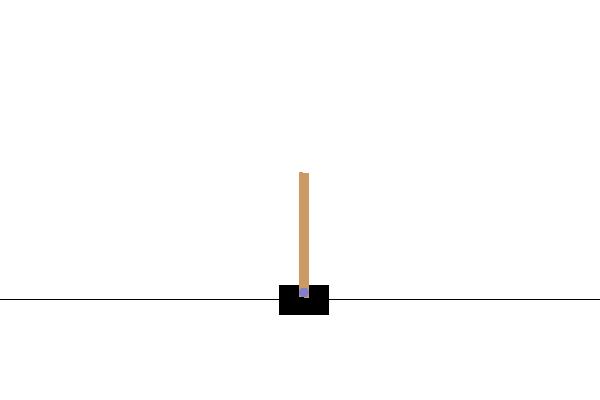

In [2]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Reset the environment and get a screenshot
train_py_env.reset()
PIL.Image.fromarray(train_py_env.render())

#### Define the Policy Neural Network
Sometimes this is also called "Actor Network".

In [3]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

#### Define the RL Algorithm

In [4]:
train_step_counter = tf.compat.v2.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [5]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

#### Define Replay Buffer

In [6]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [7]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://github.com/tensorflow/agents/blob/master/tf_agents/docs/python/tf_agents/drivers.md

In [8]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<DatasetV1Adapter shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [9]:
iterator = iter(dataset)

print(iterator)

#### Train(or Play)

In [10]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = utils.compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = utils.compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 50: Average Return = 9.100000381469727
step = 100: Average Return = 10.0
step = 150: Average Return = 9.0
step = 200: Average Return = 9.300000190734863
step = 250: Average Return = 9.0
step = 300: Average Return = 44.0
step = 350: Average Return = 42.70000076293945
step = 400: Average Return = 19.899999618530273
step = 450: Average Return = 20.0
step = 500: Average Return = 44.70000076293945
step = 550: Average Return = 29.100000381469727
step = 600: Average Return = 29.899999618530273
step = 650: Average Return = 31.899999618530273
step = 700: Average Return = 26.5
step = 750: Average Return = 28.899999618530273
step = 800: Average Return = 24.5
step = 850: Average Return = 25.5
step = 900: Average Return = 33.79999923706055
step = 950: Average Return = 28.799999237060547
step = 1000: Average Return = 27.0
step = 1050: Average Return = 34.099998474121094
step = 1100: Average Return = 16.5
step = 1150: Average Return = 21.799999237060547
step = 1200: Average Return = 19.8999996

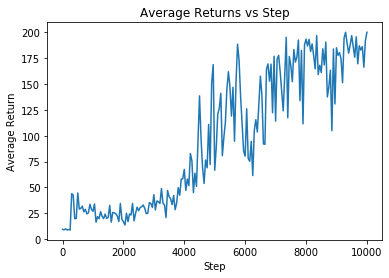

In [11]:
steps = range(0, num_iterations + 1, eval_interval)
utils.plot_avg_returns_by_step(steps, returns)

In [12]:
num_episodes = 3
video_filename = 'imageio.mp4'
utils. make_video(video_filename, eval_env, eval_py_env, agent, num_episodes=num_episodes)
utils.embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
